# Test Basic

In [1]:
using AutomotiveDrivingModels
using AutoScenes
using AutoViz
using Base.Test

INFO: Recompiling stale cache file /home/tim/.julia/lib/v0.4/AutoScenes.ji for module AutoScenes.


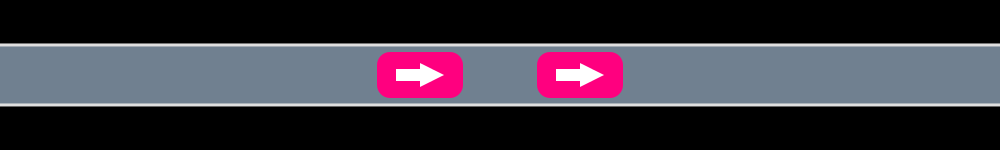

In [2]:
roadway = gen_straight_roadway(1)
scene = Scene([
    Vehicle(VehicleState(VecSE2(100.0,0.0,0.0), roadway, 1.0), VehicleDef(1, AgentClass.CAR, 4.0, 2.0)),
    Vehicle(VehicleState(VecSE2(108.0,0.0,0.0), roadway, 2.0), VehicleDef(2, AgentClass.CAR, 4.0, 2.0)),
])
render(scene, roadway, cam=SceneFollowCamera(20.0), canvas_height=150)

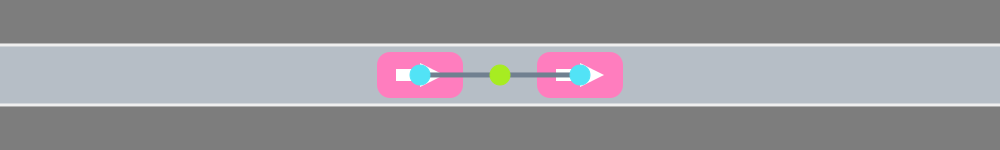

In [3]:
structure = SceneStructure([
    FactorAssignment(FeatureForms.ROAD, [1]),
    FactorAssignment(FeatureForms.ROAD, [2]),
    FactorAssignment(FeatureForms.FOLLOW, [1,2]),
    ], Set{Int}([1,2]), LeadFollowRelationships([2,0], [0,1]))
overlays = SceneOverlay[Overwash(RGBA(1.0,1.0,1.0,0.7)), SceneStructureOverlay(structure)]
render(scene, roadway, overlays, cam=SceneFollowCamera(20.0), canvas_height=150)

In [4]:
vehdefs = Dict{Int, VehicleDef}()
vehdefs[1] = scene[1].def
vehdefs[2] = scene[2].def

states = [TrajdataState(1, scene[1].state),
          TrajdataState(2, scene[2].state)]

frames = [TrajdataFrame(1,2,0.0)]

dset = SceneStructureDataset(
    [Trajdata(roadway, vehdefs, states, frames)],
    [AutoScenes.SceneSource(1, 1)],
    [structure],
    create_shared_factors(),
)

length(dset)

1

In [5]:
ϕ_road = dset.factors[1] # shared factor
vehicle_indeces = [1]
extract!(ϕ_road, scene, roadway, vehicle_indeces)
@test ϕ_road.template.values == [1.0]
@test evaluate(ϕ_road.template, ϕ_road.instances[1]) == 1.0
@test evaluate(ϕ_road.template, ϕ_road.instances[2]) == 1.0^2
@test evaluate_dot(ϕ_road) == 1.1

In [6]:
vehicle_indeces = [2]
extract!(ϕ_road, scene, roadway, vehicle_indeces)
@test ϕ_road.template.values == [2.0]
@test evaluate(ϕ_road.template, ϕ_road.instances[1]) == 2.0
@test evaluate(ϕ_road.template, ϕ_road.instances[2]) == 2.0^2
@test evaluate_dot(ϕ_road) == 2.4

In [7]:
ϕ_follow = dset.factors[2] # shared factor
vehicle_indeces = [1,2]
extract!(ϕ_follow, scene, roadway, vehicle_indeces)
@test ϕ_follow.template.values == [1.0]
@test evaluate(ϕ_follow.template, ϕ_follow.instances[1]) == 1.0
@test evaluate_dot(ϕ_follow) == 1.0

In [8]:
@test evaluate_dot!(structure, dset.factors, scene, roadway, SceneRecord(1,0.1)) == 4.5

In [9]:
plog = calc_pseudolikelihood(dset, dat = PseudolikelihoodPrealloc(100000))
@test isapprox(plog, -0.40484, atol=0.001)

In [10]:
grad = calc_pseudolikelihood_gradient(FeatureForms.ROAD, 1, dset, 1, 100000, 0.0)
@test isapprox(grad, 0.35208, atol=0.005)